<a href="https://colab.research.google.com/github/PranavG200/BTMS-WITH-PCM-AND-LIQUID-COOLING/blob/master/TRANSIENT_1D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math

''' Constants '''

g = 10      # m/s2. Acceleration due to gravity

# Battery related constants
cell_radius =  0.008        # m. Radius of cell
cell_length = 0.065      # m
cell_volume = math.pi * cell_radius**2 * cell_length       # m3. Volume of battery
k_cell = 3      # W/m/K. Thermal conductivity
resistance_cell = 30*10**-3    # ohm. Internal resistance of battery
voltage = 3.6      # V. Nominal voltage of battery
entropy_coeff = 0.4*10**-3    # V/K. Entropy coefficient due to the chemical reaction in the cell
current = voltage/resistance_cell          # Amp. Current of charge or discharge          

# CPCM related constants
Ti_CPCM = 40   # C. Initial temperaute of CPCM
viscosity_CPCM = 10**5    # kg/m/s
CPCM_thickness = 0.004 #0.002500762681055087      # m. Thickness pf CPCM
k_CPCM = 5.74

# Water related constants
Ti_water = 26.42     # C. Initial temperature of water
k_water = 0.63       # W/m/K at 40C. Thermal conductivity
density_water = 991.2     # kg/m3
Cp_water = 4174        # J/kg/K
viscosity_water = 6.533 * (10**-4)      # kg/m/s
FlowVelocity = 0.04 ###0.009        # m/s. This is the maximum liquid flow velocity
                           # Range for flow velocity = 0.02-0.14 m/s
alpha = k_water/density_water/Cp_water
Re_water = 2063.45          # This is calculated by density_water*FlowVelocity*(Diameter of inlet)/viscosity_water   
                            # Since Re is smaller than 2300, laminar flow is selected for simulation 

Dia_inlet =  Re_water*viscosity_water/density_water/FlowVelocity    

Nu = 2.9 ##2.9   # Nusselt number for FlowVelocity 0.14 = hD/k
h_water = Nu*k_water/Dia_inlet            # W/m2/K

# Setup related constants
T_wall = 25  

pipe_length = cell_length
pipe_thickness = 0.006 #Dia_inlet/2.0        # m. Thickness of coolant pipe

r_inner = cell_radius
r_middle = r_inner + CPCM_thickness 
r_outer = r_middle + pipe_thickness 

P_atm = 1

nodes_cell = 7
nodes_CPCM = 7
nodes_water = 7
nodes_r1 = nodes_cell + nodes_CPCM 
nodes_r = nodes_cell + nodes_CPCM + nodes_water     # Total nodes in r direction
nodes_z = 12    # Total nodes in z direction

''' Initialization of variables '''

r_cell = np.linspace(0, cell_radius, nodes_cell)
dr_cell = cell_radius/(nodes_cell-1)
delta_r_cell = np.ones(nodes_cell)*dr_cell
delta_rw_cell = np.copy(delta_r_cell)
delta_rw_cell[0] = 0 
delta_re_cell = np.copy(delta_r_cell)
delta_re_cell[nodes_cell-1] = 0 
delta_r_cell[0] = dr_cell/2
delta_r_cell[nodes_cell-1] = dr_cell/2

r_CPCM = np.linspace(r_inner, r_middle, nodes_CPCM)
dr_CPCM = CPCM_thickness/(nodes_CPCM-1)
delta_r_CPCM = np.ones(nodes_CPCM)*dr_CPCM
delta_rw_CPCM = np.copy(delta_r_CPCM)
delta_rw_CPCM[0] = 0 
delta_re_CPCM = np.copy(delta_r_CPCM)
delta_re_CPCM[nodes_CPCM-1] = 0 
delta_r_CPCM[0] = dr_CPCM/2
delta_r_CPCM[nodes_CPCM-1] = dr_CPCM/2

r_water = np.linspace(r_middle, r_outer, nodes_water)
dr_water = pipe_thickness/(nodes_water-1)
delta_r_water = np.ones(nodes_water)*dr_water
delta_rw_water = np.copy(delta_r_water)
delta_rw_water[0] = 0 
delta_re_water = np.copy(delta_r_water)
delta_re_water[nodes_water-1] = 0 
delta_r_water[0] = dr_water/2
delta_r_water[nodes_water-1] = dr_water/2

r_model = np.linspace(0, r_outer, nodes_r)
dr = r_outer/(nodes_r-1)
delta_r = np.ones(nodes_r)*dr
delta_rw = np.copy(delta_r)
delta_rw[0] = 0 
delta_re = np.copy(delta_r)
delta_re[nodes_r-1] = 0 
delta_r[0] = dr/2
delta_r[nodes_r-1] = dr/2

xp = [] 

for i in range(nodes_r):
  xp.append(i*dr)

radius = np.zeros((nodes_r))
for ii in range(nodes_r):
  if ii<7:
    radius[ii] = r_cell[ii]
  elif ii >6 and ii <14:
    radius[ii] = r_CPCM[ii-7]
  else:
    radius[ii] = r_water[ii-14]   

del_r = np.zeros((nodes_r))
del_r[0:nodes_r] = 0.024/20
del_r
r_model = radius

# 1D
Temp = np.zeros((nodes_r))
CAW = np.zeros((nodes_r))
CAE = np.zeros((nodes_r))
S = np.zeros((nodes_r,4))
CAP = np.zeros((nodes_r))

CAW[0] = 0
CAW[1] = 0
CAE[0] = 0
CAE[1] = k_cell*r_model[2]/r_model[1]/del_r[1]**2
S[0:7,1] = 7000
S[0:7,0] = 5000
S[0:7,2] = 10000
S[0:7,3] = 100000

for i in range(2,nodes_cell-1):
  CAW[i] = k_cell/del_r[i]**2                
  CAE[i] = k_cell*r_model[i+1] / r_model[i] / del_r[i]**2 

CAW[nodes_cell-1] = k_cell/del_r[nodes_cell-1]**2  
CAE[nodes_cell-1] = k_CPCM* r_model[i+1] / r_model[i] / del_r[i]**2 

for i in range(nodes_cell, nodes_r1-1):
  CAW[i] = r_model[i]
  CAE[i] = r_model[i+1]

CAW[nodes_r1-1] = (r_model[nodes_r1-1])/ del_r[nodes_r1-1] 
CAE[nodes_r1-1] = r_model[nodes_r1]*h_water/k_CPCM

for i in range(nodes_r1,nodes_r-1):
  CAW[i] = 1/del_r[i]**2                
  CAE[i] = r_model[i+1] / r_model[i] / del_r[i]**2 

CAW[nodes_r-1]=1/ del_r[nodes_r-1]**2

del_T =1
cp= 750
CAPO = np.zeros((nodes_r))
for i in range(1,nodes_r-1):
  CAPO[i] = density_water*cp/ del_T 

CAP = CAW + CAE + CAPO
xlheat_flux = 0
T_b = 27

TEMP1 = np.zeros((nodes_r,2000))
T_Initial=np.zeros((nodes_r,2000))   #c
T_Initial[nodes_r-1,:]= T_wall   
T_Initial[:,0]=27
r_ini = np.zeros((nodes_r))
T_b = 26
jj = 0
rmaxt =1
S1 = np.zeros((nodes_r))
while rmaxt > 7e-09:
  for ii in range(nodes_r):
    S1[ii]= CAPO[ii]*T_Initial[ii,jj]+ S[ii,3]
  jj=jj+1
  rmax_ini = 1
  for kkw in range(9990):
  #while rmax_ini >0.1:

  ## for battery core ##
    T_Initial[1,jj]= (CAE[1]/CAP[1])*T_Initial[2,jj] + S1[ii]/CAP[1] 
    T_Initial[0,jj] = T_Initial[1,jj]
    for ii in range(2,nodes_cell-1):
       T_Initial[ii,jj]=(CAW[ii]/CAP[ii])*T_Initial[ii-1,jj] + (CAE[ii]/CAP[ii])*T_Initial[ii+1,jj] + S1[ii]/CAP[ii]

   ## battery pcm interface ##
    T_Initial[nodes_cell-1,jj]=(CAW[nodes_cell-1]/CAP[nodes_cell-1])*T_Initial[nodes_cell-2,jj] + (CAE[nodes_cell-1]/CAP[nodes_cell-1])*T_Initial[nodes_cell,jj] + S1[nodes_cell-1]/CAP[nodes_cell-1]

   ## pcm ##
    for ii in range(nodes_cell,nodes_cell+ nodes_CPCM-1):
       T_Initial[ii,jj]=(CAW[ii]/CAP[ii])*T_Initial[ii-1,jj] + (CAE[ii]/CAP[ii])*T_Initial[ii+1,jj] + S1[ii]/CAP[ii]
  
  ## pcm liquid interface ##
    T_Initial[nodes_cell+ nodes_CPCM-1,jj]=(CAW[nodes_cell+ nodes_CPCM-1]/CAP[nodes_cell+ nodes_CPCM-1])*T_Initial[nodes_cell-2,jj] + (CAE[nodes_cell+ nodes_CPCM-1]/CAP[nodes_cell+ nodes_CPCM-1])*T_b + S1[nodes_r1-1]/CAP[nodes_r1-1] #c

  ## liquid ##
    for ii in range(nodes_r1,nodes_r -1):            #c
      T_Initial[ii,jj]=(CAW[ii]/CAP[ii])*T_Initial[ii-1,jj] + (CAE[ii]/CAP[ii])*T_Initial[ii+1,jj]  + S1[ii]/CAP[ii]   #c

    r_ini[1] = abs(CAE[1]*T_Initial[2,jj] + S1[1]- CAP[1]*T_Initial[1,jj])
    for ii in range(2,nodes_cell-1):
      r_ini[ii] = abs(CAW[ii]*T_Initial[ii-1,jj] + CAE[ii]*T_Initial[ii+1,jj] + S1[ii]- CAP[ii]*T_Initial[ii,jj]) 
  
    r_ini[nodes_cell-1]= abs(CAW[nodes_cell-1]*T_Initial[nodes_cell-2,jj] + CAE[nodes_cell-1]*T_Initial[nodes_cell,jj] + S1[nodes_cell-1]- CAP[nodes_cell-1]*T_Initial[nodes_cell-1,jj])

    for ii in range(nodes_cell,nodes_cell+ nodes_CPCM-1):
      r_ini[ii] = abs(CAW[ii]*T_Initial[ii-1,jj] + CAE[ii]*T_Initial[ii+1,jj]+ S1[ii] - CAP[ii]*T_Initial[ii,jj])

    r_ini[nodes_cell+ nodes_CPCM-1]= abs(CAW[nodes_cell+ nodes_CPCM-1]*T_Initial[nodes_cell+ nodes_CPCM-2,jj]+ S1[nodes_r1-1] + CAE[nodes_cell+ nodes_CPCM-1]*T_Initial[nodes_r1,jj] - CAP[nodes_cell+ nodes_CPCM-1]*T_Initial[nodes_cell+ nodes_CPCM-1,jj])

    for ii in range(nodes_r1,nodes_r-1):          #c
      r_ini[ii] = abs(CAW[ii]*T_Initial[ii-1,jj] + CAE[ii]*T_Initial[ii+1,jj] + S1[ii]- CAP[ii]*T_Initial[ii,jj])   
    
    #r_ini[nodes_r-1] = abs(CAW[nodes_r-1]*T_Initial[nodes_r-2] - CAP[nodes_r-1]*T_Initial[nodes_r-1])
    rmax_ini = max(r_ini) 
  rt=abs(np.divide((T_Initial[:,jj]-T_Initial[:,jj-1]),T_Initial[:,jj-1]))
  rmaxt = max(rt)


KeyboardInterrupt: ignored

In [ ]:
jj

173

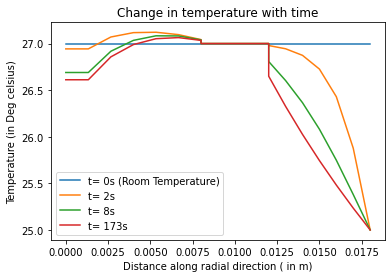

In [ ]:
plt.plot(r_model,T_Initial[:,0], label='t= 0s (Room Temperature)')
plt.plot(r_model,T_Initial[:,2], label='t= 2s')
plt.plot(r_model,T_Initial[:,8], label='t= 8s')
plt.plot(r_model,T_Initial[:,173], label='t= 173s')
plt.xlabel('Distance along radial direction ( in m)')
plt.ylabel('Temperature (in Deg celsius)')
plt.title('Change in temperature with time')
plt.legend()
plt.show()

In [ ]:
T_Initial

array([[27.        , 27.03589419, 27.03483892, ...,  0.        ,
         0.        ,  0.        ],
       [27.        , 27.03589419, 27.03483892, ...,  0.        ,
         0.        ,  0.        ],
       [27.        , 27.03590188, 27.0352235 , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [27.        , 25.48893357, 25.48144101, ...,  0.        ,
         0.        ,  0.        ],
       [27.        , 25.23858105, 25.23384573, ...,  0.        ,
         0.        ,  0.        ],
       [27.        , 25.        , 25.        , ..., 25.        ,
        25.        , 25.        ]])